In [111]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
from scipy import optimize as opt
from scipy.optimize import broyden1, minimize
from scipy import stats as sts
from matplotlib import pyplot as plt
from functools import partial
from statsmodels.formula import api as sm

# Lucas Tree Model

In [3]:
start = datetime.datetime(1970, 10, 1)
end = datetime.datetime(2018, 7, 1)

rpce = web.DataReader('PCECC96', 'fred', start, end)
w5000 = web.DataReader('WILL5000INDFC', 'fred', start, end)
gdpdef = web.DataReader('GDPDEF', 'fred', start, end)
tbill = web.DataReader('TB3MS', 'fred', start, end)

tbill = tbill.fillna(method="ffill")
w5000 = w5000.fillna(method="ffill")
tbill = tbill.resample('QS').first()
w5000 = w5000.resample('QS').first()

In [4]:
df = pd.DataFrame(columns=['rpce', 'w5000', 'tbill', 'gdpdef'], index = rpce.index)

In [6]:
df['rpce'] = rpce
df['w5000'] = w5000
df['tbill'] = tbill / 100 + 1
df['gdpdef'] = (gdpdef / 100)
df['gdpdef'] /= df['gdpdef'][0]
df['real_w5000'] = df['w5000'] / (df['gdpdef'])
df['R'] = df['real_w5000'] / df['real_w5000'].shift(1)

In [7]:
df.head()

,rpce,w5000,tbill,gdpdef,real_w5000,R
DATE,,,,,,
1970-10-01,3097.520,1.00,1.0591,1.000000,1.000000,NaN
1971-01-01,3156.978,1.00,1.0444,1.015189,0.985039,0.985039
1971-04-01,3185.993,1.12,1.0386,1.028518,1.088945,1.105485
1971-07-01,3211.394,1.13,1.0540,1.038992,1.087593,0.998758
1971-10-01,3264.679,1.12,1.0446,1.047651,1.069058,0.982958


In [8]:
df.dropna(axis=0, inplace=True)
df.head()

,rpce,w5000,tbill,gdpdef,real_w5000,R
DATE,,,,,,
1971-01-01,3156.978,1.00,1.0444,1.015189,0.985039,0.985039
1971-04-01,3185.993,1.12,1.0386,1.028518,1.088945,1.105485
1971-07-01,3211.394,1.13,1.0540,1.038992,1.087593,0.998758
1971-10-01,3264.679,1.12,1.0446,1.047651,1.069058,0.982958
1972-01-01,3307.767,1.18,1.0338,1.063565,1.109476,1.037807


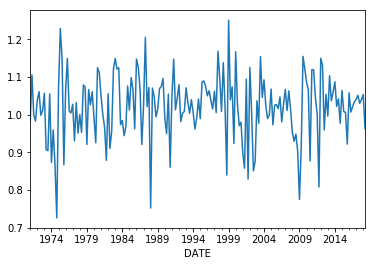

In [9]:
df['R'].plot()
plt.show()

## 1.

In [10]:
beta = 0.99

In [24]:
def sdf(gamma, df, beta):
    mu = df['rpce'] ** (-gamma)
    return beta * (mu.shift(-1) / mu)

In [25]:
def objective(gamma, *args):
    df, beta = args
    Rt1 = df['R']
    mut1 = sdf(gamma, df, beta)
    return 1 - mut1.cov(Rt1) - mut1.mean() * Rt1.mean()

In [26]:
result_1 = opt.root(objective, 1.0, args=(df, beta))
gamma_opt = result_1.x[0]
print(gamma_opt)

1.36436184116


## 2.

Check if different equations yield the same result, or do a robustness analysis using different data.

## 3.

In [27]:
def objective_2(γ, *args):
    df, β = args
    rf = df['tbill']
    E_mt1 = sdf(γ, df, β).mean()
    errors = rf - (1 / E_mt1)
    return np.sum(errors ** 2)

In [28]:
result_2 = opt.root(objective_2, 1.0, args=(df, beta))
gamma_opt2 = result_2.x[0]
print(gamma_opt2)

4.87489793515


## 4.

In [93]:
def errors(β, γ, df):
    Rt1 = df['R']
    mt1 = sdf(γ, df, β)
    error_1 = 1 - mt1.cov(Rt1) - mt1.mean() * Rt1.mean()
    rf = df['tbill']
    E_mt1 = mt1.mean()
    error_2 = np.sum((rf - (1 / E_mt1)) ** 2)
    return np.array([error_1, error_2])

def objective_3(params, df):
    β, γ = params
    return np.sum(errors(β, γ, df) ** 2)

In [94]:
guess = np.array([1.0, 3.0])
result_4 = opt.minimize(objective_3, guess, args=df)
opt_β_4, opt_γ_4 = result_4.x
print(f'γ = {opt_γ_4}\nβ = {opt_β_4}')

γ = 3.000621412681393
β = 0.9768725802759675


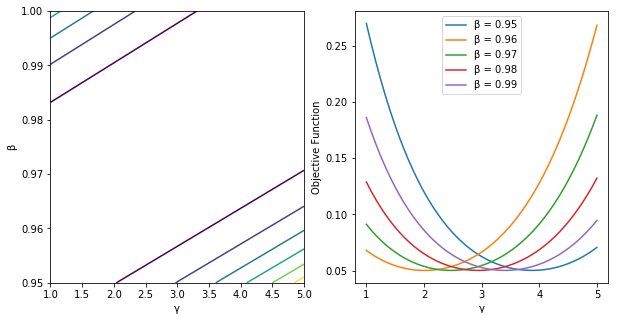

In [95]:
β_grid = np.linspace(0.95, 1, 50)
γ_grid = np.linspace(1, 5, 50)

Β, Γ = np.meshgrid(β_grid, γ_grid)
obj = np.empty_like(Β)
for i, γ in enumerate(γ_grid):
    for j, β in enumerate(β_grid):
        obj[i, j] = objective_3([β, γ], df)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].contour(Γ, Β, obj)
axes[0].set_xlabel("γ")
axes[0].set_ylabel("β")
for i, β in enumerate(β_grid[::10]):
    axes[1].plot(γ_grid, obj[10 * (i - 1)], label=f"β = {round(β, 2)}")
axes[1].legend()
axes[1].set_xlabel("γ")
axes[1].set_ylabel("Objective Function")
plt.show()

# Kyle Orderbook Model
### 1.

In [75]:
import pickle

In [76]:
AAPL = pickle.load(open("./data/AAPL", "rb"))
C = pickle.load(open("./data/C", "rb"))
GBX = pickle.load(open("./data/GBX", "rb"))
SPY = pickle.load(open("./data/SPY", "rb"))
THO = pickle.load(open("./data/THO", "rb"))

In [179]:
class OrderBook:

    def __init__(self, data, window, name):
        
        self.data = data[1]
        self.timestamp = data[0]
        self.lower = window[0]
        self.upper = window[1]
        self.name = name
        df = pd.DataFrame.from_dict(self.data, orient='index')
    
        df.columns = ['Quantity', 'Type', 'NaN0','NaN1']
        df = df[['Quantity', 'Type']]
        
        self.demand = df[df['Type'] == 'B'].sort_index(ascending=False)
        self.supply = df[df['Type'] == 'S'].sort_index()
        self.demand['QD'] = -self.demand['Quantity'].cumsum()
        self.supply['QS'] = self.supply['Quantity'].cumsum()
        
        orders = pd.concat([self.demand, self.supply])
        orders = orders.fillna(0)
        orders['Q'] = orders['QD'] + orders['QS']
        self.midpoint = orders[orders.Q < 0].index.values[0]
        
        self.orders = orders[(orders.index > window[0] * self.midpoint) 
                             & (orders.index < window[1]* self.midpoint)]
        
        self.Q = self.orders['Q']
        self.P = self.orders.index.values
                
    def est(self):
        slope, intercept, r_value, p_value, std_err = sts.linregress(self.P, self.Q)
        self.gamma = intercept
        self.beta = slope
        self.price = - self.gamma/self.beta
        self.ratio = self.beta    

    def plot(self):
        fig = plt.figure(figsize=(10,7))
        plt.plot(self.demand.index.values, self.demand['QD'], label='demand')
        plt.plot(self.supply.index.values, self.supply['QS'], label='supply')
        p_grid = np.linspace(self.lower * self.midpoint, self.upper * self.midpoint)
        plt.plot(p_grid, self.gamma + self.beta * p_grid, 'k', label='Estimated Equation')
        plt.xlim(0.5 * self.midpoint, 1.5 * self.midpoint)
        plt.xlabel('Price')
        plt.ylabel('Quantity')
        plt.title(self.name + ' Stock at t = %i' %self.timestamp)
        plt.legend()
        plt.show()
        
    def compare(self):
        print("The estimated market clearing price of", self.name, "is: %f" %self.price)
        print("The actual midpoint of the BBO of", self.name, "is: %f" %self.midpoint)
        
    def show(self):
        self.est()
        self.plot()

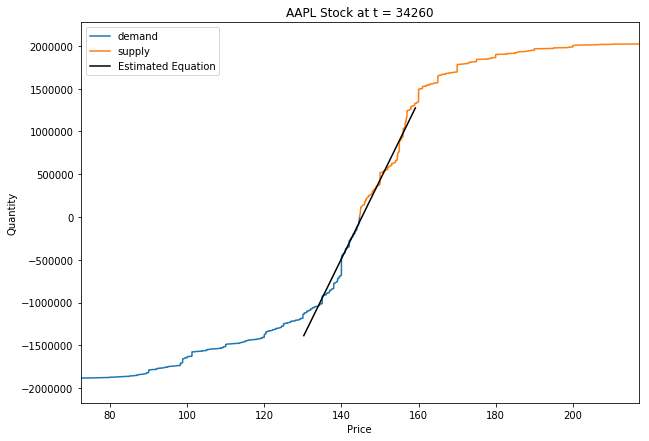

In [180]:
aapl0 = OrderBook(AAPL[0], (0.9, 1.1), "AAPL")
aapl0.show()

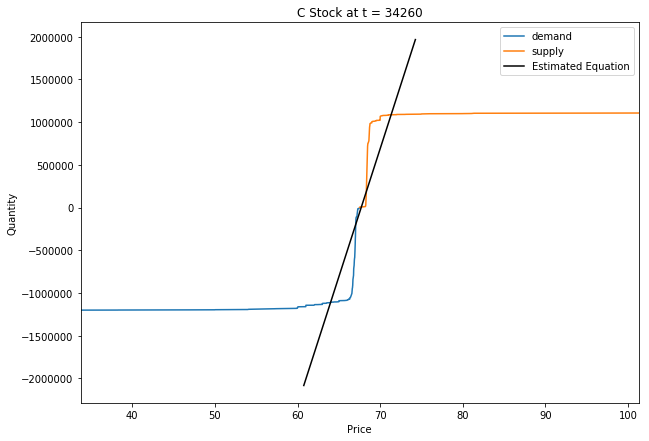

In [194]:
cl0 = OrderBook(C[0], (0.9, 1.1), "C")
cl0.show()

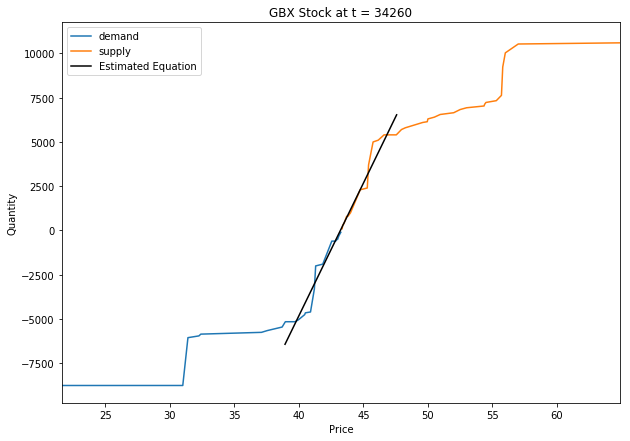

In [195]:
gbxl0 = OrderBook(GBX[0], (0.9, 1.1), "GBX")
gbxl0.show()

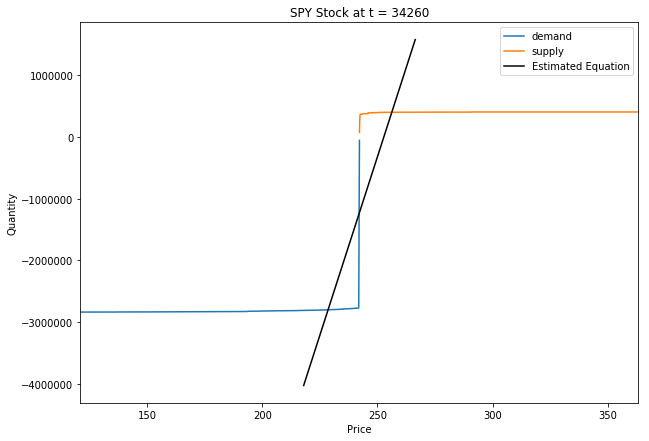

In [196]:
spyl0 = OrderBook(SPY[0], (0.9, 1.1), "SPY")
spyl0.show()

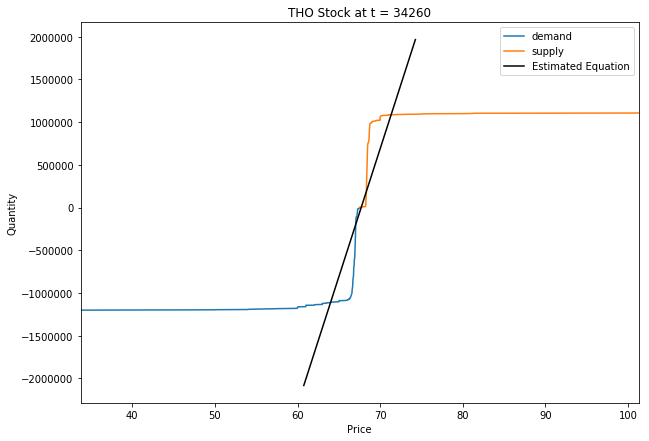

In [197]:
thol0 = OrderBook(C[0], (0.9, 1.1), "THO")
thol0.show()

The model fits especially well in the middle where demand meets supply, and fits better for AAPL and GBX. One might want to only use the center subset of the orderbook to estimate the model (close to the current trading price).

### 2.

In [185]:
def plot_ratios(file_obj, name):
    ratio = np.zeros(len(file_obj), dtype=np.float64)
    for i in range(len(file_obj)):
        book = OrderBook(file_obj[i], (0.9, 1.1), name)
        book.est()
        ratio[i] = book.ratio
    
    fig = plt.figure(figsize=(10,7))
    plt.plot(ratio)
    plt.title(name)
    plt.xlabel('Time')
    plt.ylabel('Estimated Ratio')
    plt.show()

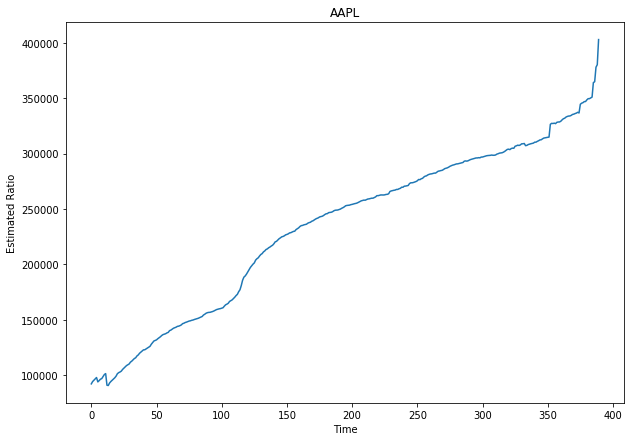

In [186]:
plot_ratios(AAPL, 'AAPL')

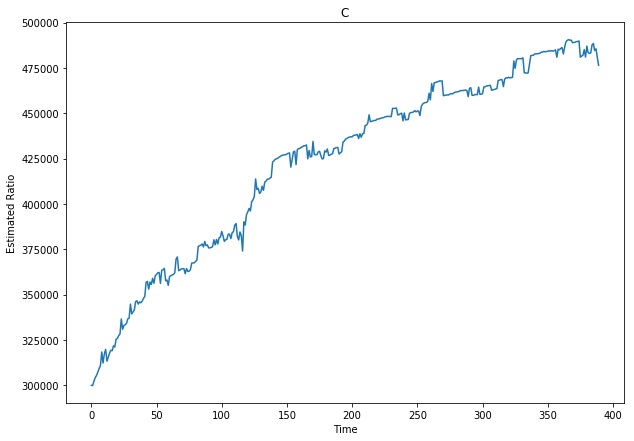

In [187]:
plot_ratios(C, 'C')

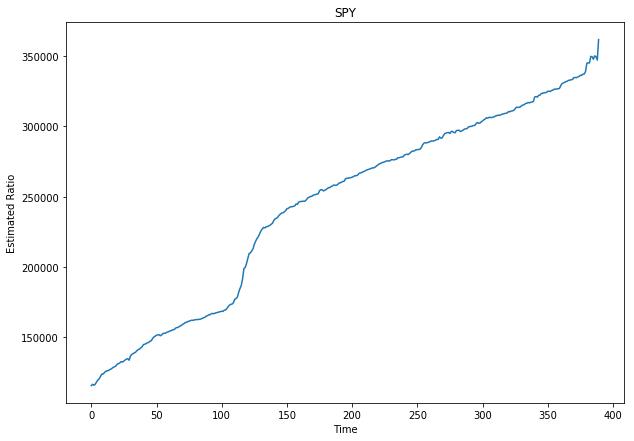

In [188]:
plot_ratios(SPY, 'SPY')

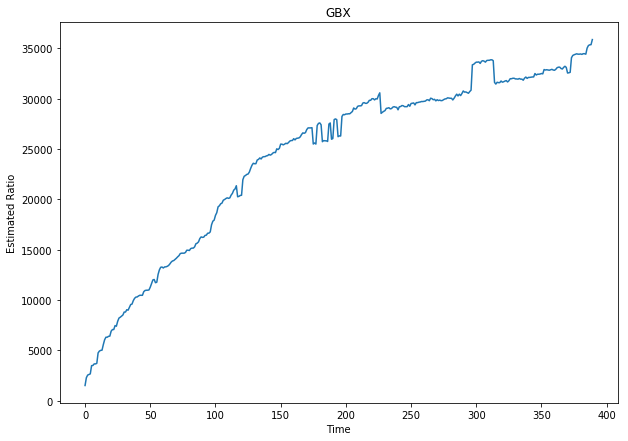

In [189]:
plot_ratios(GBX, 'GBX')

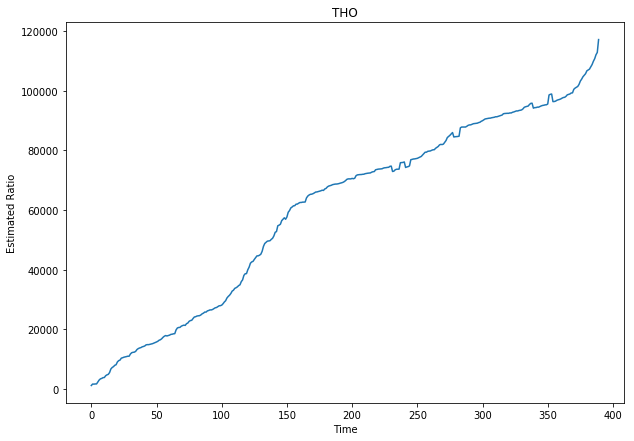

In [190]:
plot_ratios(THO, 'THO')

### 3.

In [191]:
aapl0.compare()

The estimated market clearing price of AAPL is: 145.304897
The actual midpoint of the BBO of AAPL is: 144.700000


In [200]:
cl0.compare()

The estimated market clearing price of C is: 67.706617
The actual midpoint of the BBO of C is: 67.510000


In [201]:
gbxl0.compare()

The estimated market clearing price of GBX is: 43.213939
The actual midpoint of the BBO of GBX is: 43.250000


In [202]:
spyl0.compare()

The estimated market clearing price of SPY is: 252.752189
The actual midpoint of the BBO of SPY is: 242.180000


In [203]:
thol0.compare()

The estimated market clearing price of THO is: 67.706617
The actual midpoint of the BBO of THO is: 67.510000
